<a href="https://colab.research.google.com/github/Thangleee/DetectAttackDDoS/blob/main/Detect_attack_DDoS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import thư viện

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix
import joblib

#Đọc dữ liệu

In [5]:
# Đọc file
df = pd.read_csv("/content/drive/MyDrive/DA/data/my_train_datasets.csv")

In [6]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.252.128-192.168.252.129-80-15518-17,192.168.252.129,15518,192.168.252.128,80,17,24/06/2025 08:35:49 PM,26523288,8,1,...,0,15223799.0,0.000000e+00,15223799.0,15223799.0,5649744.5,3.236308e+05,5878586.0,5420903.0,DDoS
1,192.168.252.128-192.168.252.129-80-55326-17,192.168.252.129,55326,192.168.252.128,80,17,24/06/2025 08:35:54 PM,22448738,7,1,...,0,4668233.0,3.063863e+06,6834711.0,2501755.0,6556136.0,2.714399e+05,6748073.0,6364199.0,DDoS
2,192.168.252.128-192.168.252.129-80-10471-6,192.168.252.129,10471,192.168.252.128,80,6,21/06/2025 01:06:38 AM,93438373,1,3,...,0,716.0,0.000000e+00,716.0,716.0,93436626.0,0.000000e+00,93436626.0,93436626.0,BENIGN
3,192.168.252.128-192.168.252.129-80-3312-17,192.168.252.129,3312,192.168.252.128,80,17,21/06/2025 01:06:03 AM,6745311,1,1,...,0,0.0,0.000000e+00,0.0,0.0,6745311.0,0.000000e+00,6745311.0,6745311.0,BENIGN
4,192.168.252.128-192.168.252.129-80-61882-6,192.168.252.129,61882,192.168.252.128,80,6,24/06/2025 08:35:55 PM,20787438,3,5,...,0,591591.0,8.366134e+05,1183166.0,16.0,9802088.0,1.036121e+06,10534736.0,9069440.0,DDoS


In [7]:
# Đếm số lượng BENIGN (0) và DDoS (1)
label_counts = df["Label"].value_counts()

print("Số lượng nhãn trong cột 'label':")
print(label_counts)

Số lượng nhãn trong cột 'label':
Label
DDoS      130977
BENIGN     69991
Name: count, dtype: int64


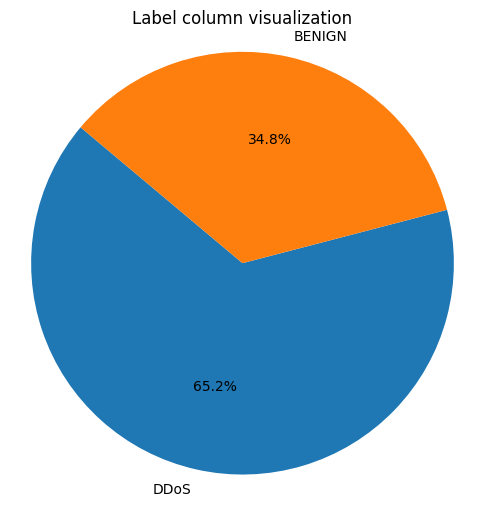

In [8]:
# Vẽ biểu đồ tròn
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Label column visualization")
plt.axis("equal")
plt.show()

#Tiền xử lý

In [9]:
# Gán nhãn nhị phân: DDOS = 1, BENIGN = 0
df["label"] = df["Label"].apply(lambda x: 1 if x == "DDoS" else 0)

In [10]:
# Bỏ các cột không dùng
drop_cols = ["Flow ID", "Src IP", "Dst IP", "Timestamp", "Label"]
df = df.drop(columns=drop_cols, errors="ignore")

In [11]:
# Kiểm tra kiểu dữ liệu còn lại
print(df.dtypes.value_counts())

float64    45
int64      35
Name: count, dtype: int64


In [12]:
# Xử lý inf và NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

In [13]:
# Đếm số lượng BENIGN (0) và DDoS (1)
label_counts = df["label"].value_counts()

print("Số lượng nhãn trong cột 'label':")
print(label_counts)

Số lượng nhãn trong cột 'label':
label
1    130976
0     69991
Name: count, dtype: int64


In [14]:
# Tách X và y
X = df.drop(columns=["label"])
y = df["label"]

# Khởi tạo scaler
scaler = StandardScaler()


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [15]:
print("The train dataset size = ",X_train.shape)
print("The test dataset size = ",X_test.shape)

The train dataset size =  (140676, 79)
The test dataset size =  (60291, 79)


#Huấn luyện mô hình

In [16]:
# Huấn luyện mô hình
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

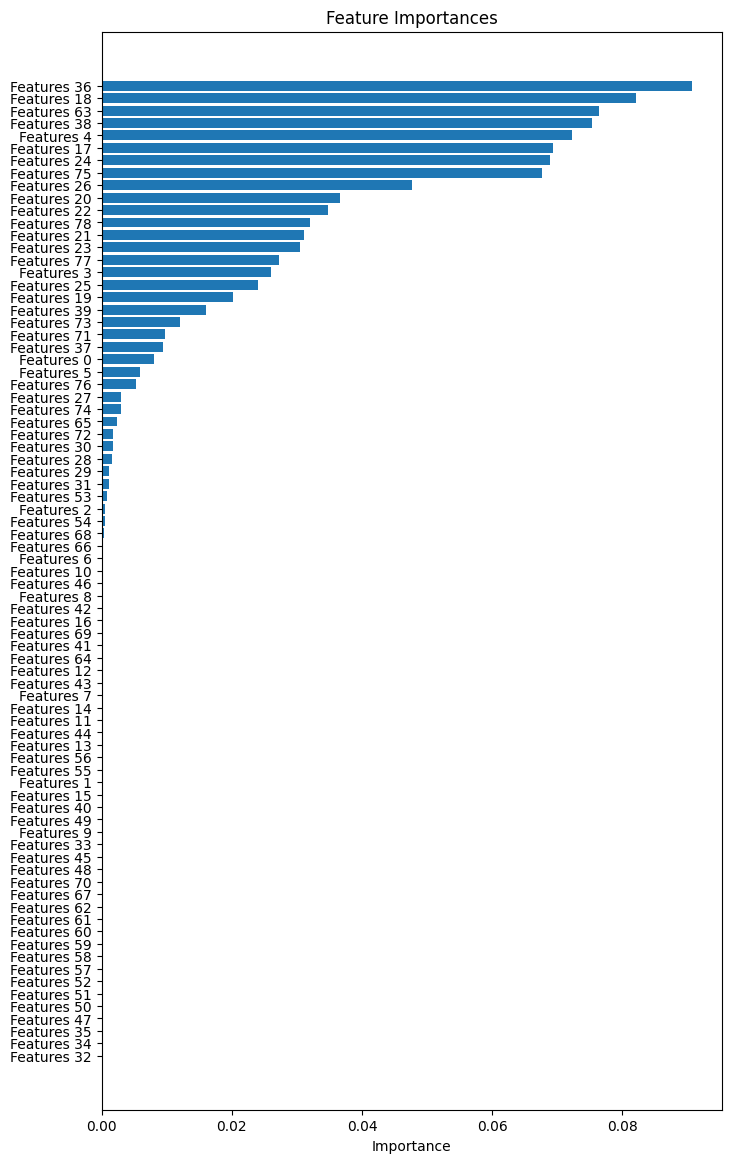

In [17]:
importances = rf_model.feature_importances_

indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=False)
feature_names = [f"Features {i}" for i in indices]

# Plotting feature importances horizontally
plt.figure(figsize=(8, 14))
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), feature_names)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

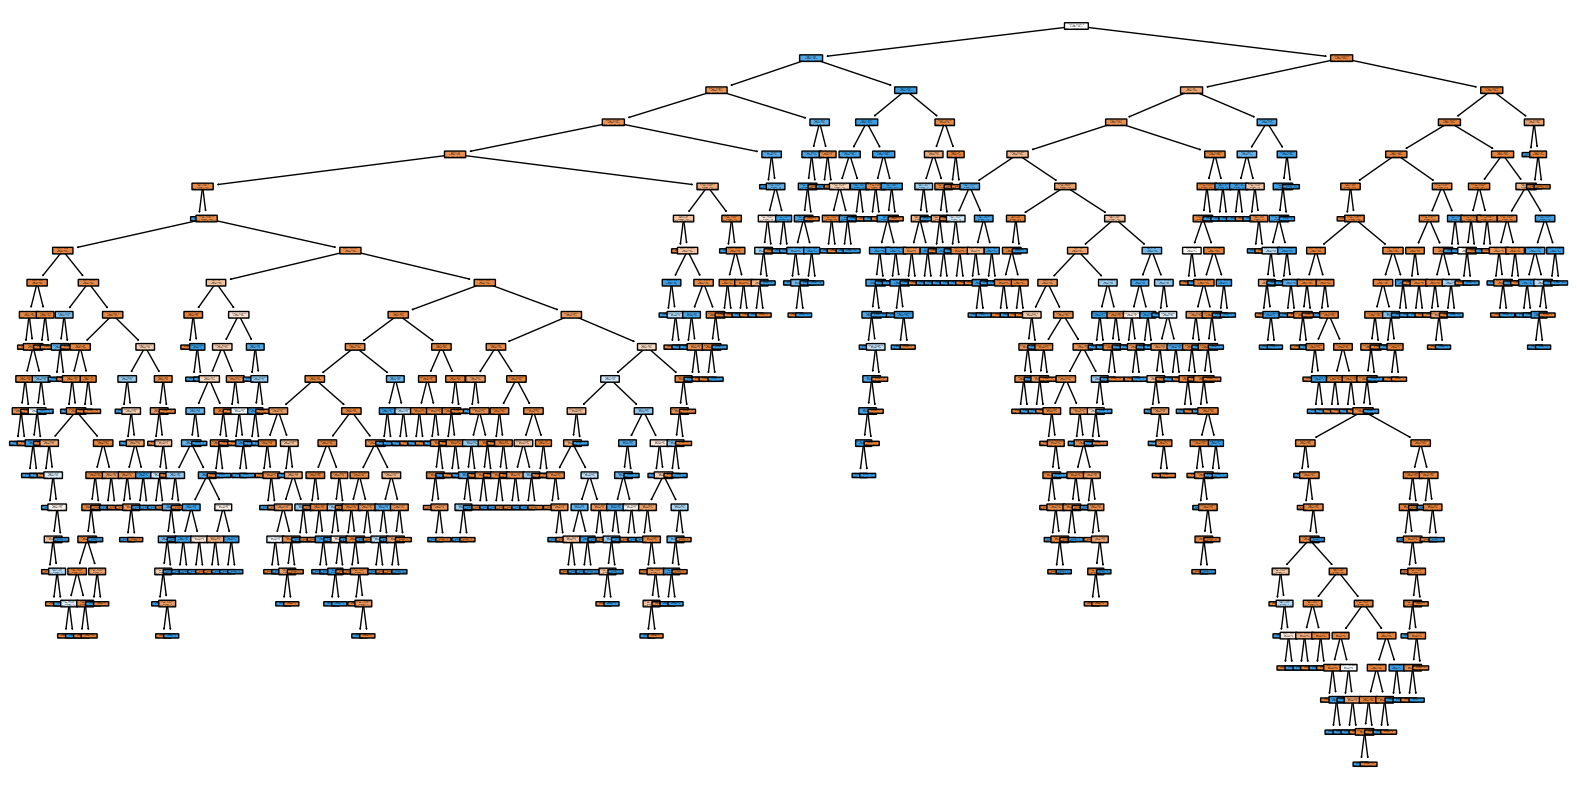

In [18]:
from sklearn.tree import plot_tree

estimator = rf_model.estimators_[0]


plt.figure(figsize=(20, 10))
plot_tree(estimator, filled=True, rounded=True)
plt.show()

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [20]:
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)

print('\nRandom Forest Metrics:')
print(f'Accuracy: {rf_accuracy:.4f}')
print(f'F1 Score: {rf_f1:.4f}')
print(f'Precision: {rf_precision:.4f}')
print(f'Recall: {rf_recall:.4f}')


Random Forest Metrics:
Accuracy: 0.9992
F1 Score: 0.9994
Precision: 0.9997
Recall: 0.9991


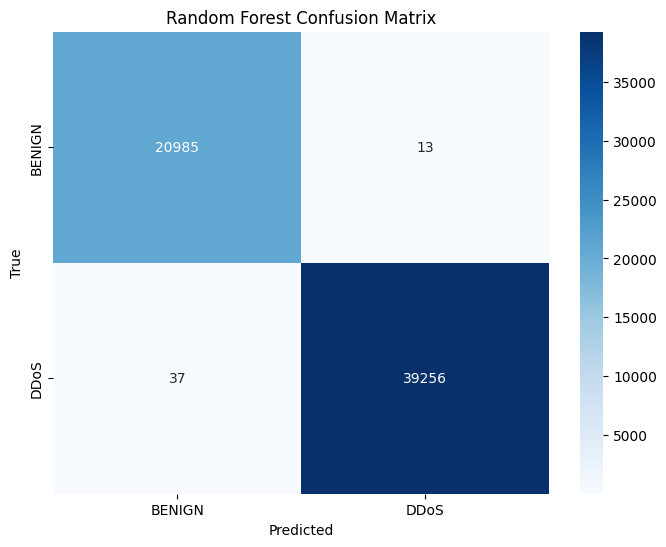

In [21]:
plot_confusion_matrix(y_test, rf_pred, ['BENIGN', 'DDoS'], 'Random Forest Confusion Matrix')

In [23]:
lr_model = LogisticRegression(random_state=42, max_iter=500)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

In [24]:
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)

print('\nLogistic Regression Metrics:')
print(f'Accuracy: {lr_accuracy:.4f}')
print(f'F1 Score: {lr_f1:.4f}')
print(f'Precision: {lr_precision:.4f}')
print(f'Recall: {lr_recall:.4f}')


Logistic Regression Metrics:
Accuracy: 0.9818
F1 Score: 0.9860
Precision: 0.9897
Recall: 0.9824


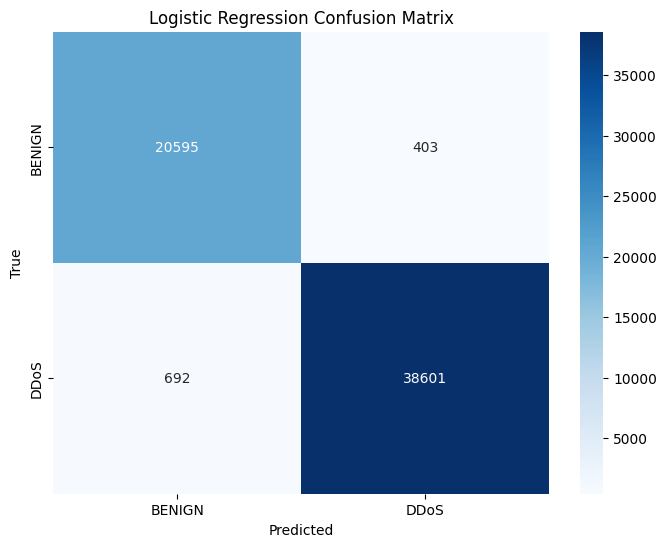

In [25]:
plot_confusion_matrix(y_test, lr_pred, ['BENIGN', 'DDoS'], 'Logistic Regression Confusion Matrix')

In [26]:
nn_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
nn_model.fit(X_train_scaled, y_train)
nn_pred = nn_model.predict(X_test_scaled)

In [27]:
nn_accuracy = accuracy_score(y_test, nn_pred)
nn_f1 = f1_score(y_test, nn_pred)
nn_precision = precision_score(y_test, nn_pred)
nn_recall = recall_score(y_test, nn_pred)

print('\nNeural Network Metrics:')
print(f'Accuracy: {nn_accuracy:.4f}')
print(f'F1 Score: {nn_f1:.4f}')
print(f'Precision: {nn_precision:.4f}')
print(f'Recall: {nn_recall:.4f}')


Neural Network Metrics:
Accuracy: 0.9911
F1 Score: 0.9932
Precision: 0.9970
Recall: 0.9894


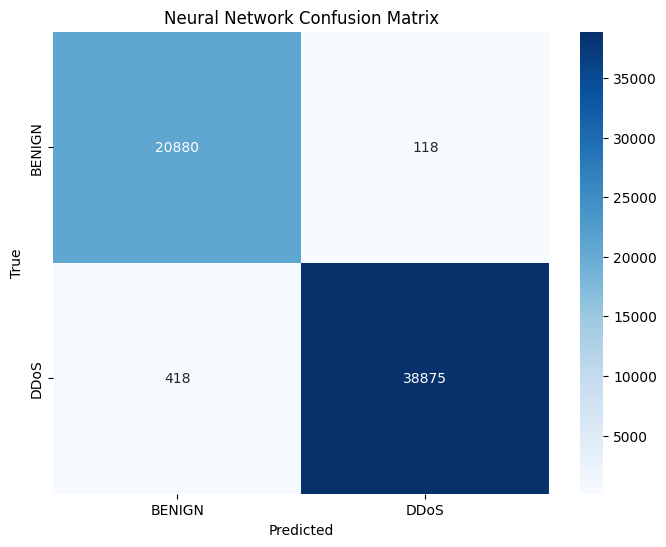

In [28]:
plot_confusion_matrix(y_test, nn_pred, ['BENIGN', 'DDoS'], 'Neural Network Confusion Matrix')

In [29]:
rf_proba = rf_model.predict_proba(X_test)

lr_proba = lr_model.predict_proba(X_test_scaled)

nn_proba = nn_model.predict_proba(X_test_scaled)

In [30]:
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_proba[:, 1])
rf_auc = auc(rf_fpr, rf_tpr)

lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_proba[:, 1])
lr_auc = auc(lr_fpr, lr_tpr)

nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_proba[:, 1])
nn_auc = auc(nn_fpr, nn_tpr)

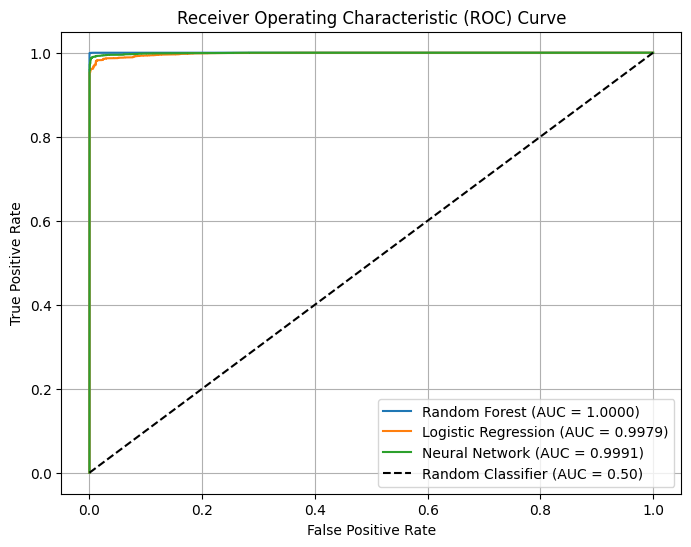

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.4f})')
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.4f})')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.4f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Classifier (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

#Lưu mô hình

In [45]:
joblib.dump(rf_model, "/content/drive/MyDrive/DA/data_rf_model.pkl")

joblib.dump(scaler, "/content/drive/MyDrive/DA/scaler.pkl")

feature_list = X.columns.to_list()
joblib.dump(feature_list, "/content/drive/MyDrive/DA/feature_list.pkl")

['/content/drive/MyDrive/DA/feature_list.pkl']